<a href="https://colab.research.google.com/github/rndbblnn/stonks-jupyter/blob/main/tz_trades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install mplfinance
!pip install backtrader

import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.image  as m_img
import pandas as pd
import numpy as np 
import json
import requests
import urllib.parse
import base64
import warnings
import logging
import io
from datetime import datetime
from PIL import Image

warnings.filterwarnings('ignore')

baseurl = 'https://af1bbf696a14.ngrok.io';

def encodeUrl(arg):
  str = arg.replace('.','%2E')
  return urllib.parse.quote(str)

def getChartDataframe(symbol, timeframe, datefrom, dateto):
    url = baseurl + '/chart/' + symbol + '/' + timeframe + '?from=' + encodeUrl(datefrom) + '&to=' + encodeUrl(dateto)
    chartResponse = requests.get(url)
    df = None
    try:
      df = pd.DataFrame(chartResponse.json()['payload'])
      df.tickTime = pd.to_datetime(df.tickTime)
      df = df.set_index('tickTime')
      return df;
    except Exception as e:
      print(e.__class__)
      print(e)
      print(chartResponse)
      print(chartResponse.text)
      return;

dummyImg = Image.new('RGB', (60, 30), color = 'black')
dummyImg.save('void.png')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 3.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.9 MB/s 


In [3]:
try:
  r = requests.post(baseurl + '/search', data={'q': q})
  df = pd.DataFrame(r.json()['payload'])
except Exception as e:
  logging.error(f"Exception Name: {type(e).__name__}")
  logging.error(f"Exception Desc: {e}")
  print(r)
  print(r.text)
  raise e

df['patternTime'] = pd.to_datetime(df['patternTime'])
print(df.head)


<bound method NDFrame.head of    symbol patternTime
0    ILPT  2022-09-22
1    NRGV  2022-09-22
2     BXC  2022-09-20
3    LOVE  2022-09-20
4    LCID  2022-09-16
..    ...         ...
95   BAND  2022-07-22
96   BFRI  2022-07-22
97   CRSR  2022-07-22
98   DCFC  2022-07-22
99   EGHT  2022-07-22

[100 rows x 2 columns]>


ILPT (2022-09-22)
entryPrice: 7.6
tickTime
2022-09-21 11:12:00    7.6
Name: low, dtype: float64


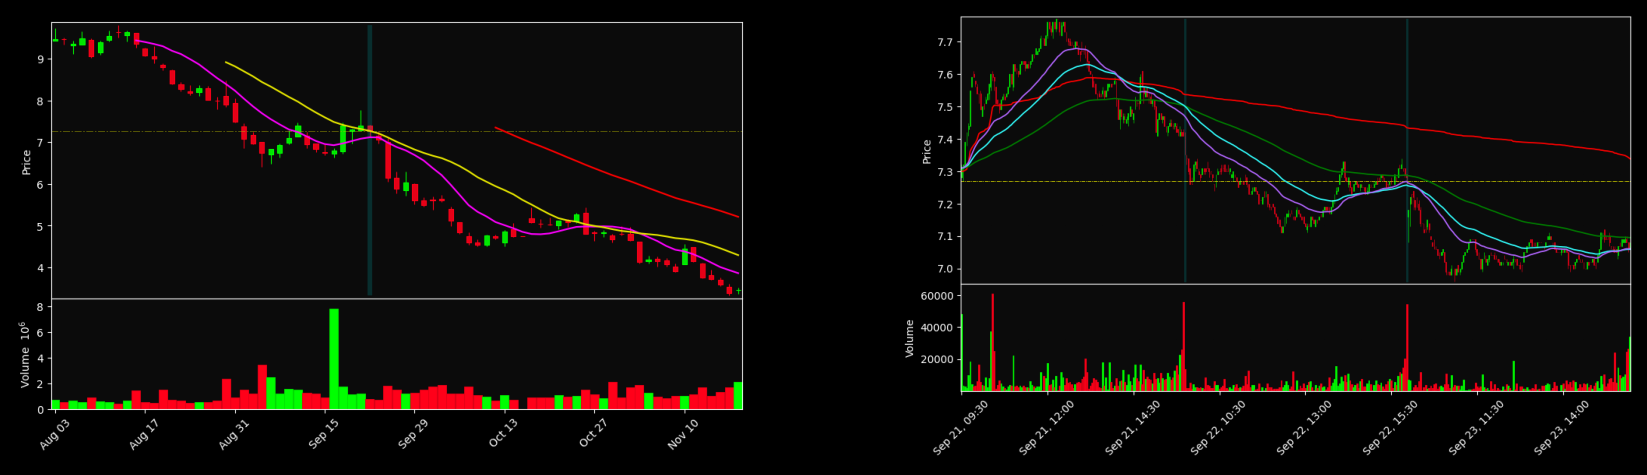

NRGV (2022-09-22)
entryPrice: 4.59
tickTime
2022-09-21 11:12:00    4.59
Name: low, dtype: float64


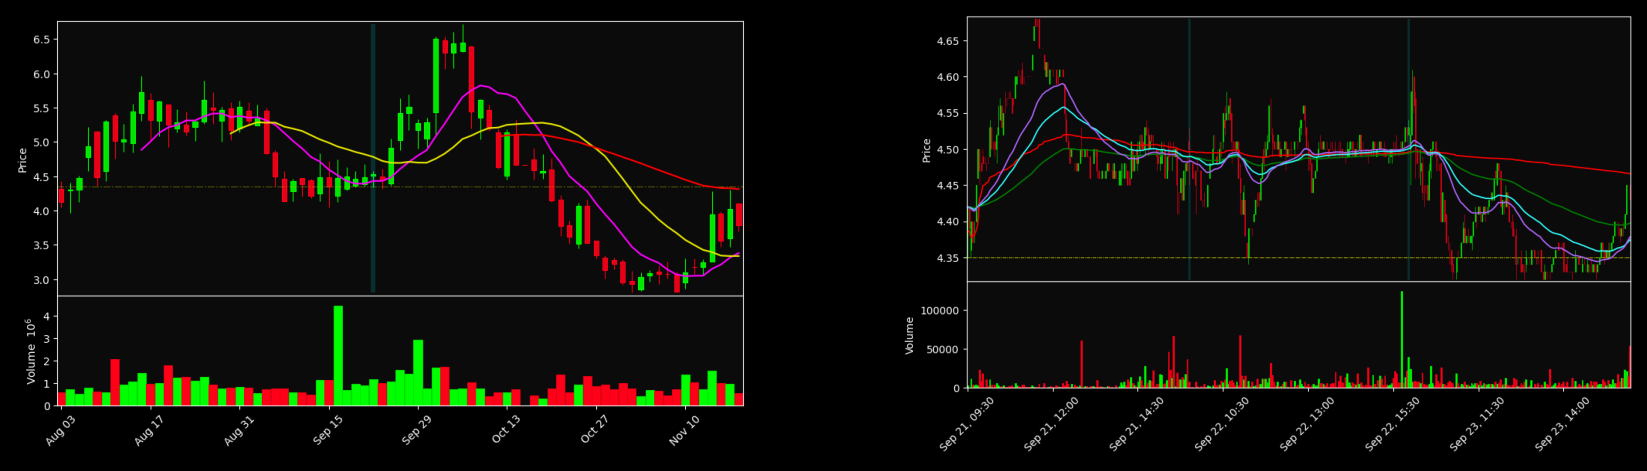

BXC (2022-09-20)
entryPrice: 67.56
tickTime
2022-09-19 11:12:00    67.56
Name: low, dtype: float64


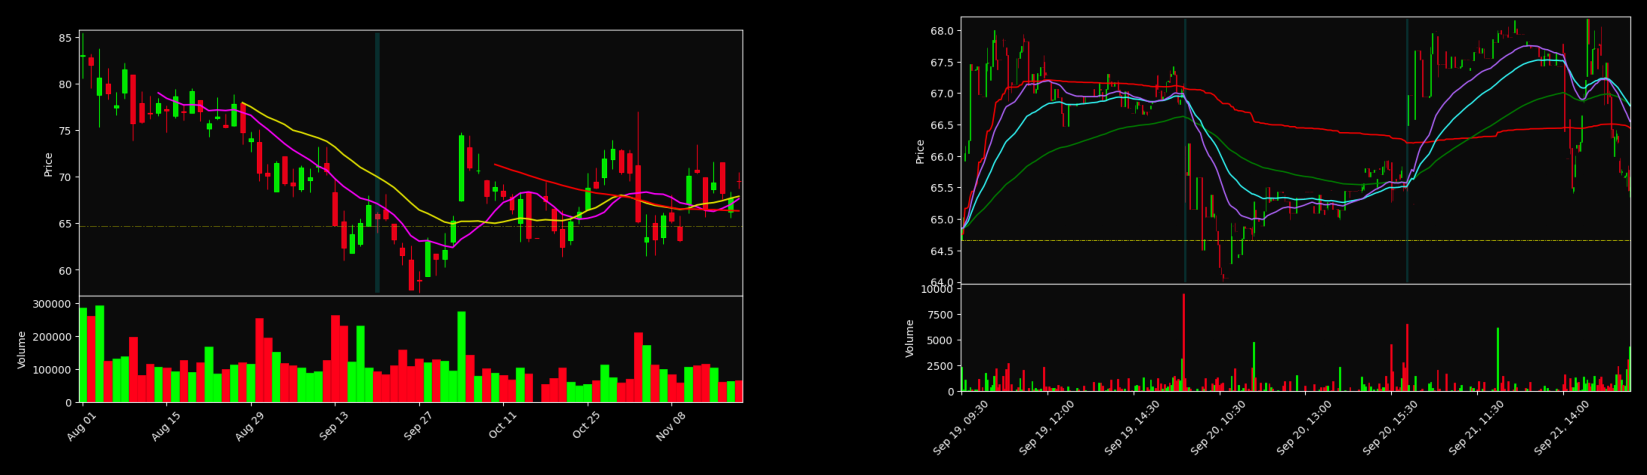

LOVE (2022-09-20)
entryPrice: 25.31
tickTime
2022-09-19 11:12:00    25.31
Name: low, dtype: float64


KeyboardInterrupt: ignored

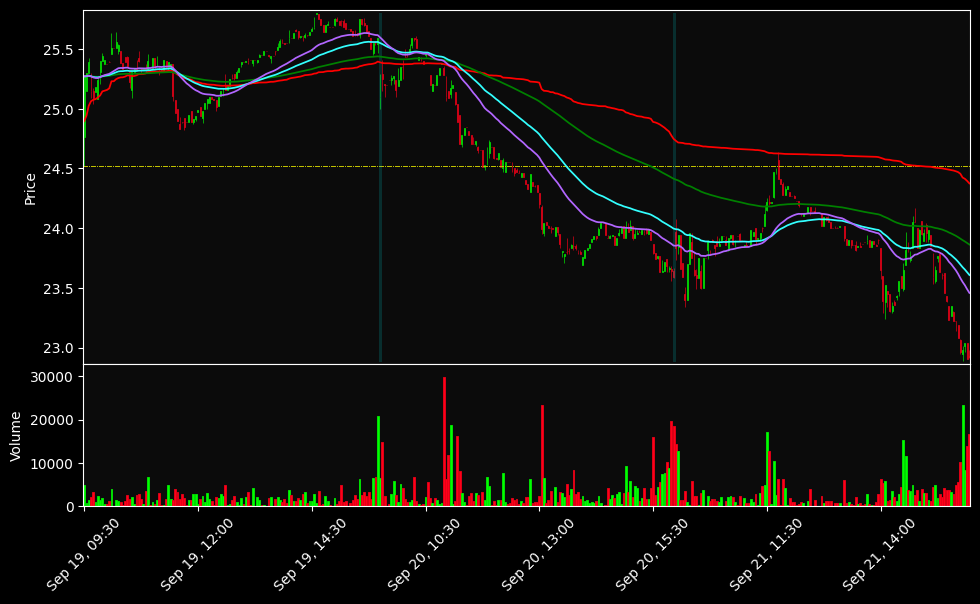

In [5]:
entryOffset = 0
mc = mpf.make_marketcolors(up='#00ff00',down='#ff0019',inherit=True)
mstyledaily  = mpf.make_mpf_style(
    base_mpf_style='nightclouds', 
    mavcolors=['magenta','#e6e600','red','green'],
    marketcolors=mc,
    gridcolor='#0b0b0b'
  )
mstyleintra = mpf.make_mpf_style(
    base_mpf_style='nightclouds', 
    mavcolors=['magenta','#e6e600','red','green'],
    marketcolors=mc,
    gridcolor='#0b0b0b'
  )

for index, row in df.iterrows():
    
    ######################################################
    # fetch daily
    ######################################################
    chartDf = getChartDataframe(
        row['symbol'], 
        'd', 
        (row['patternTime'] + pd.DateOffset(days=-50)).strftime('%Y-%m-%d'), 
        (row['patternTime'] + pd.DateOffset(days=100)).strftime('%Y-%m-%d')
      )

    entryDate = row['patternTime']
    entryStr = entryDate.strftime('%Y-%m-%d')

    idx = chartDf.index.get_loc(entryStr)
    if (entryOffset!=0):
      entryStr = chartDf.iloc[[idx+entryOffset]].index.format()[0]
      entryDate = datetime.strptime(entryStr, '%Y-%m-%d')

    print(row['symbol'] + ' (' + row['patternTime'].strftime('%Y-%m-%d') + ')')

    hlines=(
        chartDf.iloc[[idx+entryOffset-1]]['low'].values[0], 
        # chartDf.iloc[[idx+entryOffset-1]]['high'].values[0]
      )

    addplot = [
        # mpf.make_addplot(chartDf['close'].ewm(span=10, adjust=False).mean(), color='magenta'),
        # mpf.make_addplot(chartDf['close'].ewm(span=21, adjust=False).mean(), color='#e6e600'),
        # mpf.make_addplot(chartDf['close'].ewm(span=50, adjust=False).mean(), color='red'),
        # mpf.make_addplot(chartDf['close'].ewm(span=200,adjust=False).mean(), color='green'),
        # mpf.make_addplot(entryPoint1, scatter=True,  type='scatter', markersize=200, marker=entryMarker, color=entryColor),
        # mpf.make_addplot(entryPoint2, scatter=True,  type='scatter', markersize=50, marker='.', color=entryColor)
    ]

    imgDailyPlot = io.BytesIO()
    mpf.plot(chartDf, 
             type='candle', 
             volume=True, 
             mav=(10,20,50,200),
             tight_layout=True, 
             figratio=(16,9), 
             addplot=addplot,
             savefig=imgDailyPlot,
             style=mstyledaily,
             hlines=dict(hlines=hlines,colors='y',linewidths=1,alpha=0.5,linestyle='-.'),
             vlines=dict(vlines=[entryStr],colors='c',linewidths=4,alpha=0.2))
    _ = imgDailyPlot.seek(0)

    ######################################################
    # fetch intraday
    ######################################################
    start = (entryDate + pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
    end = (entryDate + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    imgIntradayPlot = io.BytesIO()

    chartDf = getChartDataframe(
        row['symbol'], 
        '3m', 
        (entryDate + pd.DateOffset(days=-1)).strftime('%Y-%m-%d'), 
        (entryDate + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
      )

    if (chartDf is None):
      imgIntradayPlot = 'void.png'
    else:
      chartDf['VWAP'] = (chartDf.volume * (chartDf.high + chartDf.low) / 2).cumsum() / chartDf.volume.cumsum()

    entryStr = entryDate.replace(hour=9, minute=30)

    entryPrice = chartDf.iloc[[idx+entryOffset-1]]['low'].values[0]
    # entryRow = chartDf.loc[chartDf['high'] >= entryPrice & chartDf['low'] <= entryPrice]

    print('entryPrice: ' + str(entryPrice))
    print(chartDf.iloc[[idx+entryOffset-1]]['low'])

    addplot  = [
      mpf.make_addplot(chartDf['VWAP'], color="red"),
      mpf.make_addplot(chartDf['close'].ewm(span=150, adjust=False).mean(), color='green'),
      mpf.make_addplot(chartDf['close'].ewm(span=63, adjust=False).mean(), color='#33ffff'),
      mpf.make_addplot(chartDf['close'].ewm(span=36, adjust=False).mean(), color='#b266ff'),
    ]

    vlines=[entryDate.replace(hour=9, minute=30), entryDate.replace(hour=15, minute=57)]

    mpf.plot(chartDf[start:end], 
          type='candle', 
          volume=True, 
          tight_layout=True, 
          figratio=(16,9),
          savefig=imgIntradayPlot,
          addplot=addplot,
          style=mstyleintra,
          hlines=dict(hlines=hlines,colors='y',linewidths=(0.5),linestyle='-.'),
          vlines=dict(vlines=vlines,colors='c',linewidths=(2),alpha=0.2))
    _ = imgIntradayPlot.seek(0)

    # daily & intraday charts
    img1 = m_img.imread(imgDailyPlot)
    img2 = m_img.imread(imgIntradayPlot)
    fig = plt.figure(figsize=(21,14))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()